# Science Use Case for HiPSCat Workshop (August 6-8, Seattle)

### Background:
There are several use cases for this application. One of them is to study the light curves of AGN in optical and infrared light. (Some) AGN have variable luminosity over time. Depending on their properties (dust torus, etc), the variability is different in the optical and infrared light. With this use case, we can study the variability of a sample of AGN at different wavelength by combining light-curves from the optical (ZTF, Pan-STARRS) and the infrared (WISE).

### Goals:
- combine ZTF, Pan-STARRS, and WISE data for a sample of galaxies. The data is in HiPSCat format and can be accessed via the cloud.
- Use nested pandas tables to create a frame holding optical and infrared light curves.
- Apply cuts on this nested pandas object (for example by luminosity, of data availability)
- Do some cross-correlation between the lightcurves to compute if they are in lockstep, offset, or not variable in either optical of infrared.
- Save everything in a final table.


### Literature and Useful Links:
- Datasets available in LSDB: https://data.lsdb.io/
- Nested Pandas tutorial: https://github.com/lincc-frameworks/notebooks_lf/blob/main/nested-pandas-mvp/nested_lincc_tech_talk.ipynb


### Authors:
- Andy Tzanidakis (DiRAC, atzanida@uw.edu)
- Sean McGuire (Carnegie Mellon, seanmcgu@andrew.cmu.edu)
- Andreas Faisst (Caltech/IPAC , afaisst@caltech.edu)




In [1]:
## Install the lastest lsdb with nested pandas
%pip install lsdb nested-dask nested-pandas aiohttp matplotlib s3fs --quiet
%pip install git+https://github.com/astronomy-commons/lsdb@sean/crossmatch-meta --quiet

import numpy as np
import pandas as pd
import lsdb
import matplotlib.pyplot as plt
import matplotlib as mpl

from nested_dask import NestedFrame
import pyarrow
import re
import healpy as hp
from hipscat.catalog import Catalog
from hipscat.catalog.catalog_info import CatalogInfo
from collections import defaultdict
from hipscat.pixel_math.healpix_pixel import HealpixPixel
from hipscat.pixel_math import hipscat_id


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import TYPE_CHECKING, Tuple

import numpy.typing as npt
import pyarrow as pa
from hipscat.pixel_math.validators import validate_radius

from lsdb.core.crossmatch.abstract_crossmatch_algorithm import AbstractCrossmatchAlgorithm
from lsdb.core.crossmatch.kdtree_utils import _find_crossmatch_indices, _get_chord_distance, _lon_lat_to_xyz
from lsdb.dask.merge_catalog_functions import generate_meta_df_for_nested_tables
import nested_pandas as npd
from scipy.spatial import KDTree

class NestedKdTreeCrossmatch(AbstractCrossmatchAlgorithm):
    """Nearest neighbor crossmatch using a 3D k-D tree"""

    @classmethod
    def validate(
        cls,
        left,
        right,
        radius_arcsec: float = 1,
        name = None
    ):
        super().validate(left, right)
        # Validate radius
        validate_radius(radius_arcsec)
        if (
            right.margin is not None
            and right.margin.hc_structure.catalog_info.margin_threshold < radius_arcsec
        ):
            raise ValueError("Cross match radius is greater than margin threshold")
            

    @classmethod
    def generate_meta_df(cls, left: Catalog, right: Catalog, suffixes: Tuple[str], radius_arcsec: float = 1, name = None):
        if name is None:
            name = right.hc_structure.catalog_info.catalog_name
        return generate_meta_df_for_nested_tables([left], right, name, [])
            
    def crossmatch(
        self,
        radius_arcsec: float = 1,
        name = None
    ):
        # Distance in 3-D space for unit sphere
        max_d_chord = _get_chord_distance(radius_arcsec)
        # calculate the cartesian coordinates of the points
        left_xyz, right_xyz = self._get_point_coordinates()
        # get matching indices for cross-matched rows
        if len(right_xyz) == 0:
            return np.array([], dtype=float), np.array([], dtype=int), np.array([], dtype=int)

        # construct the KDTree from the right catalog
        tree = KDTree(right_xyz, compact_nodes=True, balanced_tree=True, copy_data=False)

        # find the indices for the nearest neighbors
        # this is the cross-match calculation
        query_points = tree.query_ball_point(left_xyz, r=max_d_chord)
        len_joined = np.sum(np.vectorize(len)(query_points))
        
        left_idx = np.arange(len_joined)
        right_idx = np.arange(len_joined)
        
        ind = 0
        for i, matches in enumerate(query_points):
            if len(matches) == 0:
                continue
            left_idx[ind:ind+len(matches)] = np.full(len(matches), fill_value=i)
            right_idx[ind:ind + len(matches)] = np.array(matches)
            ind += len(matches)
        
        right_join_part = self.right.iloc[right_idx]
        right_join_part.index = self.left.index.to_numpy()[left_idx]
        if name is None:
            name = self.right_catalog_info.catalog_name
        joined = self.left.iloc[np.unique(left_idx)].add_nested(right_join_part, name=name)
        return joined
        

    def _get_point_coordinates(self) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
        left_xyz = _lon_lat_to_xyz(
            lon=self.left[self.left_catalog_info.ra_column].to_numpy(),
            lat=self.left[self.left_catalog_info.dec_column].to_numpy(),
        )
        right_xyz = _lon_lat_to_xyz(
            lon=self.right[self.right_catalog_info.ra_column].to_numpy(),
            lat=self.right[self.right_catalog_info.dec_column].to_numpy(),
        )
        return left_xyz, right_xyz

In [3]:
def wise_to_ab(flux , band):
    '''
    Neven is going to write a unit test.
    '''
    # convert to magnitudes
    #vega_to_ab_conv = {"W1": 2.699, "W2": 3.339, "W3": 5.174, "W4": 6.620}
    vega_to_ab_conv = [2.699,3.339,5.174,6.620]
    
    # get Vega magnitude from nanomaggy flux as described in Meisner et al. (2023)
    wise_mag_vega = 22.5 - 2.5*np.log10(flux)

    # convert Vega magnitude to AB magnitude
    wise_mag_ab = wise_mag_vega + vega_to_ab_conv[int(band)-1]
    
    flux_mjy = 10**(-0.4*(wise_mag_ab - 23.9) )  / 1e3
    
    return(wise_mag_ab, flux_mjy)


def convert_wise_flux_to_millijansky(flux_nanomaggy, *, band=None):
    """unWISE light curves flux is stored in nanomaggy. Convert to millijansky.

    See https://www.sdss3.org/dr8/algorithms/magnitudes.php and Meisner et al. (2023, https://iopscience.iop.org/article/10.3847/1538-3881/aca2ab/pdf).
    For Vega to AB conversion for WISE see https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html

    Parameters
    ----------
    flux_nanomaggy : float or iterable of floats
        Flux in nanomaggy.
    band : str
        WISE band name corresponding to flux_nanomaggy. One of "W1", "W2", "W3", "W4", or None.
        If None, band will be set to the name attribute of flux_nanomaggy. Useful when applying this 
        transform to a DataFrame grouped by band.

    Returns
    -------
    flux_mjy : float or iterable of floats 
        flux_nanomaggy converted to millijansky.
    """
    if band is None:
        band = flux_nanomaggy.name

    # Vega to AB magnitude conversions
    vega_to_ab_conv = {"W1": 2.699, "W2": 3.339, "W3": 5.174, "W4": 6.620}

    # get Vega magnitude from nanomaggy flux as described in Meisner et al. (2023)
    mag_vega = 22.5 - 2.5*np.log10(flux_nanomaggy)

    # convert Vega magnitude to AB magnitude
    mag_ab = mag_vega + vega_to_ab_conv[band]

    # convert AB magnitude to mJy
    flux_mjy = 10**(-0.4*(mag_ab - 23.9) )  / 1e3

    return flux_mjy

def load_wise():
    ## All code from Sean.
    ## Get WISE Parquet catalog
    # the catalog is stored in an AWS S3 bucket in region us-east-1
    # load the catalog's metadata as a pyarrow dataset. this will be used to query the catalog
    K = 5
    fs = pyarrow.fs.S3FileSystem(region="us-east-1")
    bucket = "irsa-mast-tike-spitzer-data"
    catalog_root = f"{bucket}/data/NEOWISE/healpix_k{K}/meisner-etal/neo7/meisner-etal-neo7.parquet"
    dataset = pyarrow.dataset.parquet_dataset(f"{catalog_root}/_metadata", filesystem=fs, partitioning="hive")

    meta = dataset.schema.empty_table().to_pandas().drop(["healpix_k5", "healpix_k0"], axis=1)
    meta.index = meta.index.astype("uint64")
    meta.index.name = hipscat_id.HIPSCAT_ID_COLUMN
    fragments = list(dataset.get_fragments())
    paths = [i.path for i in fragments]
    pixels = []
    for path in paths:
        pixel = path.split('/')[-2]
        pixels.append(int(re.findall(r'\d+', pixel.split('=')[-1])[0]))
    argsort = np.argsort(pixels)
    sorted_fragments = [fragments[i] for i in argsort]
    sorted_pixels = [pixels[i] for i in argsort]
    hp_pixels = [HealpixPixel(K, i) for i in sorted_pixels]
    cat_info = CatalogInfo(catalog_name="wise", catalog_type="object", ra_column="ra", dec_column="dec")
    frag_dict = defaultdict(list)

    for i in range(len(hp_pixels)):
        f = sorted_fragments[i]
        pixel = hp_pixels[i]
        frag_dict[pixel].append(f)

    split_frag_dict = {}
    for p, fs in frag_dict.items():
        if len(fs) > 1:
            split_amount = (np.log2(len(fs)) // 2) + 1
            order = int(K + split_amount)
            pix_inds = np.arange(p.pixel * (4 ** split_amount), (p.pixel + 1) * (4 ** split_amount))
            hp_pixels = [HealpixPixel(order, int(i)) for i in pix_inds]
            for hpp in hp_pixels:
                split_frag_dict[hpp] = fs
        else:
            split_frag_dict[p] = fs

    sorted_hp_pixels_unique = sorted(list(split_frag_dict.keys()), key=lambda p: p.pixel * (4**(29-p.order)))
    frag_list = [(p, split_frag_dict[p]) for p in sorted_hp_pixels_unique]
    def join_and_split(psandfs):
        p, fs = psandfs
        dfs = []
        for f in fs:
            df = f.to_table().to_pandas()
            ra = df["ra"].to_numpy()
            dec = df["dec"].to_numpy()
            df["hppixatorder"] = hp.ang2pix(hp.order2nside(p.order), ra, dec, nest=True, lonlat=True)
            df[hipscat_id.HIPSCAT_ID_COLUMN] = hipscat_id.compute_hipscat_id(ra, dec)
            df = df[df["hppixatorder"] == p.pixel].drop("hppixatorder", axis=1)
            df.set_index(hipscat_id.HIPSCAT_ID_COLUMN, drop=True, inplace=True)
            dfs.append(df)
        return pd.concat(dfs)
    ndf = NestedFrame.from_map(join_and_split, frag_list, meta=meta)
    hc_cat = Catalog(cat_info, sorted_hp_pixels_unique)
    pixmap = {p: i for i, p in enumerate(sorted_hp_pixels_unique)}
    wise = lsdb.Catalog(ndf, pixmap, hc_cat)
    
    return(wise)
    

## Load Pan-STARRS
Read in Pan-STARRS object catalog directly using LSDB. Only include important columns. Note that we need `objID`, which we will use later to match to the ZTF lightcurve catalog.

In [4]:
ps1_catalog = lsdb.read_hipscat('s3://stpubdata/panstarrs/ps1/public/hipscat/otmo', storage_options={'anon': True},
                               columns=["objName","objID","rMeanApMag","raMean","decMean"])


ps1_source = lsdb.read_hipscat('s3://stpubdata/panstarrs/ps1/public/hipscat/detection', storage_options={'anon': True},
                              columns=["objID","ra","dec","zp","psfFlux","psfFluxErr","filterID","obsTime"]
                              )

/opt/conda/envs/science_demo/lib/python3.11/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(
/opt/conda/envs/science_demo/lib/python3.11/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


In [5]:
ps1_source

,objID,ra,dec,zp,psfFlux,psfFluxErr,filterID,obsTime
npartitions=83004,,,,,,,,
0,int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow]
281474976710656,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
13834776580305453056,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


Apply a magnitude cut in R-band. Note that ZTF saturates around 12-13th magnitude.
Furthermore, we add a cone search around the COSMOS field. Note that we don't apply the query for now, so that the produced object is still an LSDB objects (which means we can manipulate it further easily).

In [6]:
## Let's pick a source
ra, dec = 294.34648, 17.98414


#ps1_catalog_selected = ps1_catalog.query("rMeanApMag < 16.5 and rMeanApMag > 16").cone_search(ra = 10.00 , dec = 2.00 , radius_arcsec = 1*3600)
#ps1_catalog_selected = ps1_catalog.cone_search(ra = ra , dec = dec , radius_arcsec = 1)
ps1_catalog_selected = ps1_catalog.query("rMeanApMag < 18 and rMeanApMag > 13").cone_search(ra = ra , dec = dec , radius_arcsec = 30)


In [7]:
## Join object and source catalog
ps1lc_catalog_selected = ps1_catalog_selected.join_nested(ps1_source , left_on = "objID", right_on="objID",
                                                 nested_column_name="ps_lc")

/opt/conda/envs/science_demo/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:294: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


Return the number of columns in this catalog. For this, we have to apply the query and cone search by using `.compute()`.

In [8]:
%%time
len(ps1lc_catalog_selected.compute())

CPU times: user 4.45 s, sys: 1.38 s, total: 5.83 s
Wall time: 10.9 s


9

## Load ZTF
We load the source catalog of ZTF including the ZTF light curves. We also select some important columns. Note that we need `ps1_objid` to match to the Pan-STARRS catalog.

In [9]:
ztf_catalog_source = lsdb.read_hipscat('https://data.lsdb.io/unstable/ztf/ztf_zource/' , 
                                      columns = ["ps1_objid","ra","dec","mjd","mag","magerr","band"]) # can match with ObJID

/opt/conda/envs/science_demo/lib/python3.11/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


## Match Pan-STARRS and ZTF catalog.
In the following, we match the Pan-STARRS and ZTF lightcurve catalog via the object ID columns. This creates a nested pandas frame, including the ZTF lightcurve for each of the matched sources.

In [10]:
ps1_ztf_nested = ps1lc_catalog_selected.join_nested(ztf_catalog_source , left_on = "objID", right_on="ps1_objid",
                                                 nested_column_name="ztf_lc")



/opt/conda/envs/science_demo/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:294: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


Finally, apply all the selections (magnitude, cone-search, etc) to output final nested pandas table.

In [11]:
%%time
ps1_ztf_nested_table = ps1_ztf_nested.compute()

CPU times: user 25.4 s, sys: 9.24 s, total: 34.7 s
Wall time: 19 s


In [12]:
len(ps1_ztf_nested_table)

9

## Load unWISE and Merge
Load the unWISE HiPSCat catalog and merge with the Panstarrs+ZTF catalog. Then create the final nested pandas catalog table.

In [13]:
## Load WISE catalog 
wise = load_wise()


In [14]:
## Crossmatch with WISE
ps1_ztf_wise_nested = ps1_ztf_nested.crossmatch(wise, radius_arcsec = 3, algorithm=NestedKdTreeCrossmatch , name="wise_lc")

/opt/conda/envs/science_demo/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [15]:
ps1_ztf_wise_nested

,objName,objID,rMeanApMag,raMean,decMean,ps_lc,ztf_lc,wise_lc
npartitions=8,,,,,,,,
3648478648123523072,string[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], zp: [doubl...","nested<ra: [double], dec: [double], mjd: [doub...","nested<x: [double], y: [double], flux: [float]..."
3648496240309567488,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
3648672162170011648,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


In [16]:
## Compute
ps1_ztf_wise_nested_table =  ps1_ztf_wise_nested.compute()

In [17]:
len(ps1_ztf_wise_nested_table)

9

## Get Light Curves

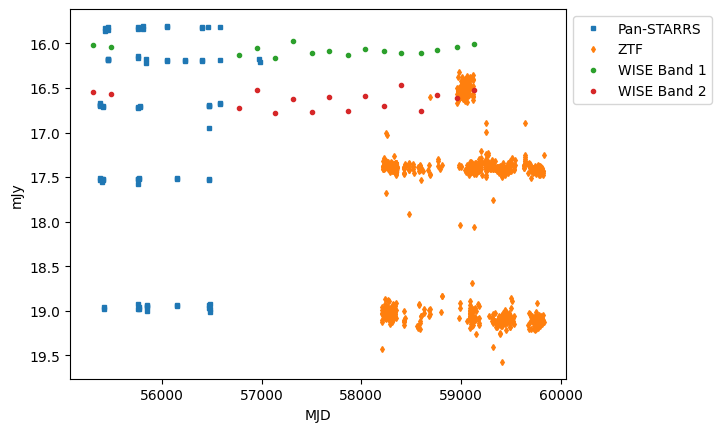

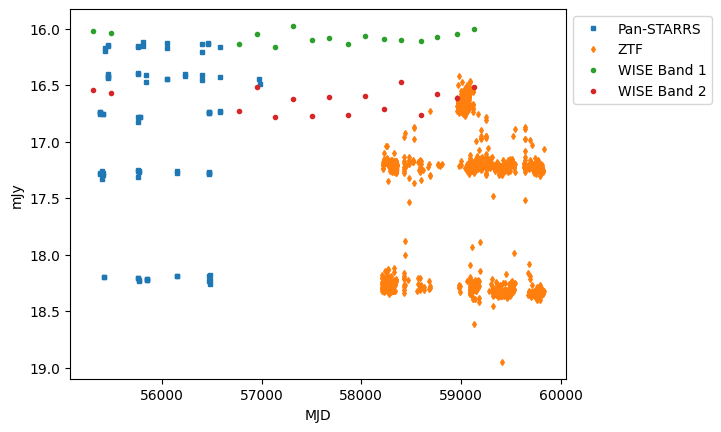

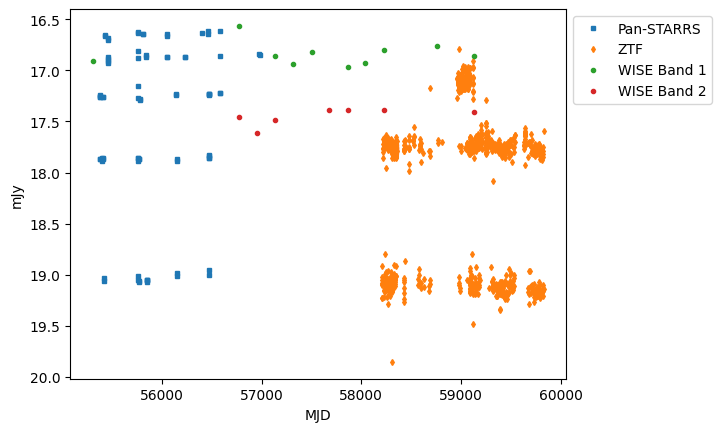

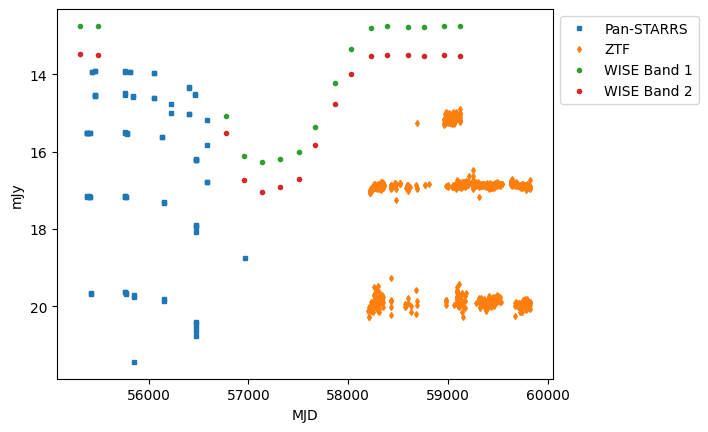

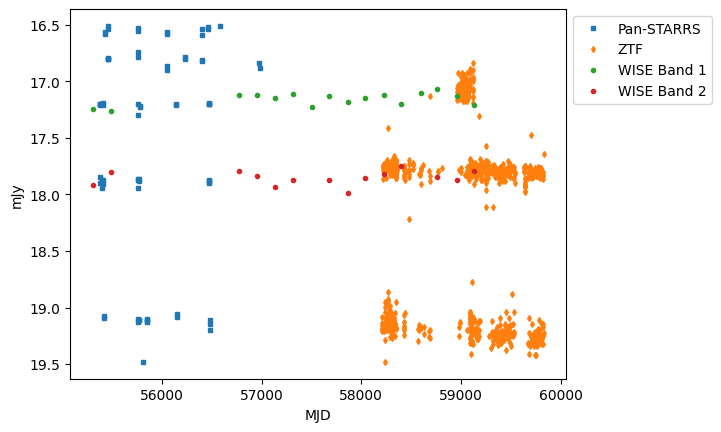

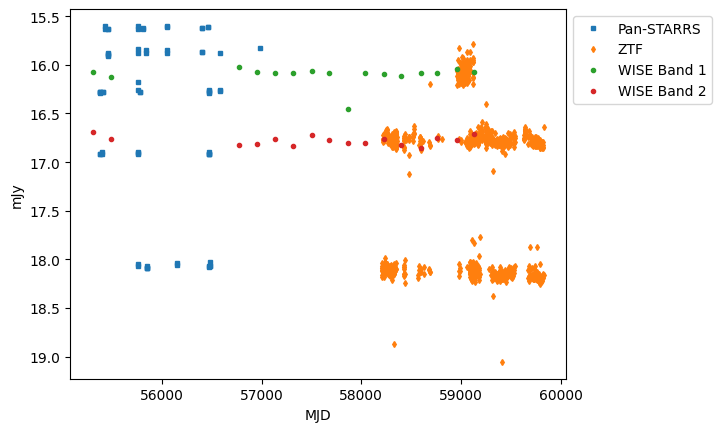

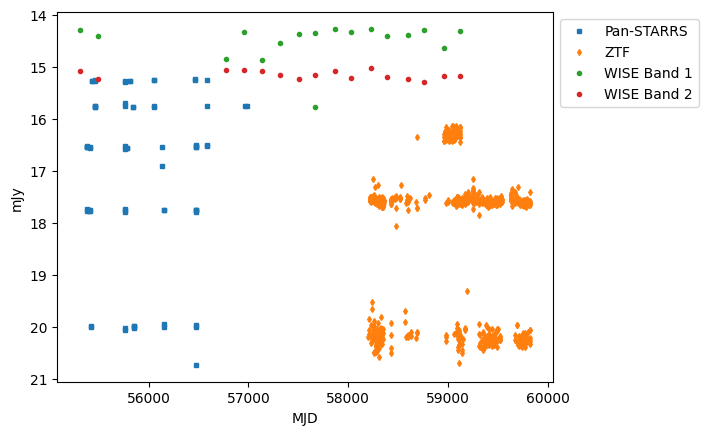

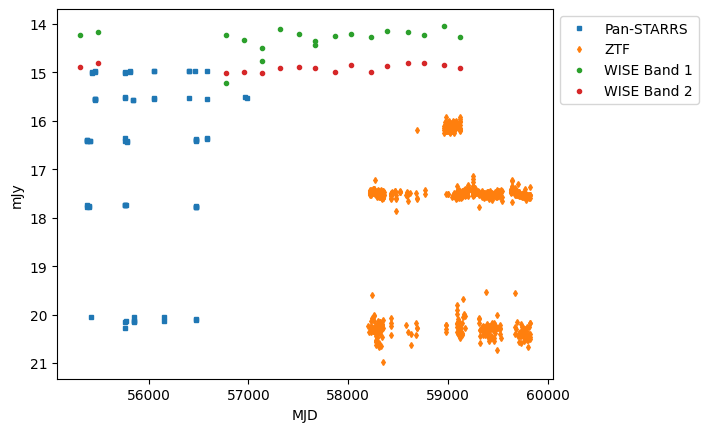

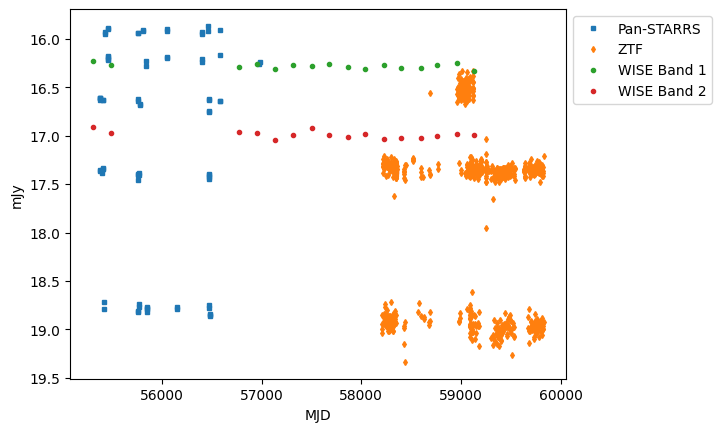

In [18]:
## Plot a light curve in WISE and ZTF (and PAN-STARRS)

for ii in range(len(ps1_ztf_wise_nested_table)):
    
    
    ## Get light curves:
    ps_lightcurve = ps1_ztf_wise_nested_table.ps_lc.values[ii]
    ztf_lightcurve = ps1_ztf_wise_nested_table.ztf_lc.values[ii]
    wise_lightcurve = ps1_ztf_wise_nested_table.wise_lc.values[ii]


    ## PANSTARRS == 
    ps_time = ps_lightcurve["obsTime"]
    ps_flux = ps_lightcurve["psfFlux"]

    # PSFflux to AB mag
    ps_mag = -2.5*np.log10(ps_flux) + 8.9

    plt.plot(ps_time , ps_mag , "s", markersize=3 , label="Pan-STARRS")


    ## ZTF == 
    ztf_time = ztf_lightcurve["mjd"]
    ztf_mag = ztf_lightcurve["mag"]
    plt.plot(ztf_time , ztf_mag , "d", markersize=3 , label="ZTF")


    ## WISE ====
    wise_time = wise_lightcurve["MJDMEAN"]
    wise_flux = wise_lightcurve["flux"]
    #wise_mag = -2.5*np.log10( wise_flux ) + 23.9 # uJy
    wise_bands = wise_lightcurve["band"]

    #mag1, flux_mjy1 = wise_to_ab(wise_flux[wise_bands == 1] , 1)
    #mag2, flux_mjy2 = wise_to_ab(wise_flux[wise_bands == 2] , 2)
    #flux_mjy1 = convert_wise_flux_to_millijansky(wise_flux[wise_bands == 1] , band = "W1")
    #flux_mjy2 = convert_wise_flux_to_millijansky(wise_flux[wise_bands == 2] , band = "W2")


    #plt.plot(wise_time[wise_bands == 1] , flux_mjy1*1e3 , "o")
    #plt.plot(wise_time[wise_bands == 2] , flux_mjy2*1e3 , "o")

    for bandid in np.unique(wise_bands):

        mag, flux_mjy = wise_to_ab(wise_flux[wise_bands == bandid] , bandid)
        plt.plot(wise_time[wise_bands == bandid] , mag , "o" , markersize=3 , label = "WISE Band {}".format(bandid))

    plt.xlabel("MJD")
    #plt.ylabel("Flux")
    #plt.ylabel("Mag")
    plt.ylabel("mJy")
    plt.legend(bbox_to_anchor=(1,1))
    plt.gca().invert_yaxis()

    plt.show()




# Analyse light curves



In [19]:
## Apply standard deviation and others to ZTF and WISE bands
def nested_std(ztf_x , ps_x):
    
    ztf_flux = 10**(-0.4*(ztf_x - 23.9))
    
    output = {"ztf_r_std":np.std(ztf_flux),
             "ps_r_std":np.std(ps_x),
              "ztf_r_med":np.median(ztf_flux),
             "ps_r_med":np.median(ps_x)
             }
    return( output)


ps1_ztf_wise_nested_reduced = ps1_ztf_wise_nested.query("ps_lc.filterID == 2").query("ztf_lc.band == 'r' ").reduce(nested_std , "ztf_lc.mag","ps_lc.psfFlux", 
                                                                                    meta = {"ztf_r_std":float,"ps_r_std":float,"ztf_r_med":float,"ps_r_med":float}
                                                                                    )
#ps1_ztf_wise_nested_reduced_table = ps1_ztf_wise_nested_reduced.compute()


In [20]:
## Attach results again to main object
ps1_ztf_wise_nested_analyze = ps1_ztf_wise_nested_reduced.merge(ps1_ztf_wise_nested, left_index=True , right_index=True)




In [21]:
ps1_ztf_wise_nested_analyze

,ztf_r_std,ps_r_std,ztf_r_med,ps_r_med,objName,objID,rMeanApMag,raMean,decMean,ps_lc,ztf_lc,wise_lc
npartitions=8,,,,,,,,,,,,
3648478648123523072,float64,float64,float64,float64,string[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], zp: [double], psfFlux: [double], psfFluxErr: [double], filterID: [int16], obsTime: [double]>","nested<ra: [double], dec: [double], mjd: [double], mag: [float], magerr: [float], band: [string]>","nested<x: [double], y: [double], flux: [float], dx: [float], dy: [float], dflux: [float], qf: [float], rchi2: [float], fracflux: [float], fluxlbs: [float], dfluxlbs: [float], fwhm: [float], spread_model: [float], dspread_model: [float], fluxiso: [float], xiso: [double], yiso: [double], sky: [float], ra: [double], dec: [double], coadd_id: [large_string], band: [int32], unwise_detid: [large_string], nm: [int16], primary: [int16], flags_unwise: [int16], flags_info: [int16], EPOCH: [int16], FORWARD: [int16], MJDMIN: [double], MJDMAX: [double], MJDMEAN: [double]>"
3648496240309567488,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
3648672162170011648,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...
